<a href="https://colab.research.google.com/drive/1UKdapnaA_Q4zXWNjVVNHOJKnagVDsyAa" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

### Loading model file(.py)

In [1]:
!git clone https://github.com/ak112/TSAI-EVA8.0
!mv /content/TSAI-EVA8.0/05_NormalizationRegularization/*.py .
!rm -rf /content/TSAI-EVA8.0


### Loading Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import *
     

### Data Transformation

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Creating Training/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Dataloader Arguments & Test/Train Dataloaders

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(normalizationMethod='GN').to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0

### Training and Testing

In [7]:
from tqdm import tqdm

train_losses = {"BN":[],"GN":[],"LN":[]}
test_losses = {"BN":[],"GN":[],"LN":[]}
train_acc = {"BN":[],"GN":[],"LN":[]}
test_acc = {"BN":[],"GN":[],"LN":[]}

def train(model, device, train_loader, optimizer, epoch, runName, L1flag=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)


    # L1 Regularization
    if L1flag:
        l1_lambda = 1.0e-5
        l1_loss = torch.tensor(0., requires_grad=True)
        l1_loss=l1_loss.to(device)
        for name, param in model.named_parameters():
            l1_loss = l1_loss + l1_lambda*(torch.norm(param, 1))
        loss=loss+l1_loss

    train_losses[runName].append(loss.item())
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc[runName].append(100*correct/processed)

def test(model, device, test_loader, runName):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses[runName].append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc[runName].append(100. * correct / len(test_loader.dataset))

### Group Normalization(Model)

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net(normalizationMethod='GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='GN')
    scheduler.step()
    test(model, device, test_loader, runName='GN')

EPOCH: 0


Loss=0.10323399305343628 Batch_id=468 Accuracy=86.74: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]



Test set: Average loss: 0.0805, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.13049112260341644 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]



Test set: Average loss: 0.0551, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.12584008276462555 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0450, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.0627923533320427 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0420, Accuracy: 9869/10000 (98.69%)

EPOCH: 4


Loss=0.04064669832587242 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]



Test set: Average loss: 0.0354, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.08253634721040726 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.0422, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


Loss=0.03929884359240532 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]



Test set: Average loss: 0.0277, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.007833861745893955 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 26.69it/s]



Test set: Average loss: 0.0283, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.050908442586660385 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 27.09it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.04768773540854454 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.49it/s]



Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

EPOCH: 10


Loss=0.03448004275560379 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 26.97it/s]



Test set: Average loss: 0.0261, Accuracy: 9913/10000 (99.13%)

EPOCH: 11


Loss=0.03053472936153412 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]



Test set: Average loss: 0.0265, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.01853303797543049 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 26.92it/s]



Test set: Average loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.010393056087195873 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]



Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.010224900208413601 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]



Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.019603634253144264 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:17<00:00, 26.95it/s]



Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.045184601098299026 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]



Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.05505630001425743 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.011694026179611683 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


Loss=0.019727611914277077 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:17<00:00, 27.17it/s]



Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)



### Misclassified Images(GN)

In [13]:
import matplotlib.pyplot as plt

def misclassified_images(model, test_loader):
    # set model to evaluation mode
    model.eval()

    misclassified_images = []
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    misclassified_images.append(data[i])
                    actual_labels.append(target[i])
                    predicted_labels.append(pred[i])

    # Plot the misclassified images
    fig = plt.figure(figsize=(10, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        plt.imshow(misclassified_images[i].cpu().numpy().squeeze(), cmap='gray', interpolation='none')
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()


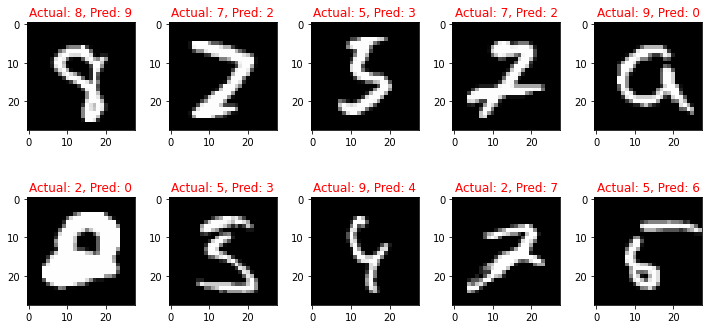

In [15]:
misclassified_images(model, test_loader)

### Layer Normalization

In [12]:
model =  Net(normalizationMethod='LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='LN')
    scheduler.step()
    test(model, device, test_loader, runName='LN')

EPOCH: 0


Loss=0.09867309778928757 Batch_id=468 Accuracy=87.80: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0741, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.11619224399328232 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]



Test set: Average loss: 0.0588, Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.08933719992637634 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]



Test set: Average loss: 0.0453, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.057705581188201904 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]



Test set: Average loss: 0.0514, Accuracy: 9845/10000 (98.45%)

EPOCH: 4


Loss=0.06538286060094833 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:17<00:00, 26.61it/s]



Test set: Average loss: 0.0316, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.04200109839439392 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0292, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.015086171217262745 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.0636075809597969 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]



Test set: Average loss: 0.0255, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.02794749289751053 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]



Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.03926670923829079 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]



Test set: Average loss: 0.0244, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.013330577872693539 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.33it/s]



Test set: Average loss: 0.0251, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.09897083044052124 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0252, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.0446416437625885 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]



Test set: Average loss: 0.0243, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.06068737804889679 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0239, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.07659458369016647 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.13146495819091797 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0238, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.10833794623613358 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]



Test set: Average loss: 0.0235, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Loss=0.011348315514624119 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]



Test set: Average loss: 0.0237, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


Loss=0.037984203547239304 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]



Test set: Average loss: 0.0237, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.0703117772936821 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0237, Accuracy: 9922/10000 (99.22%)



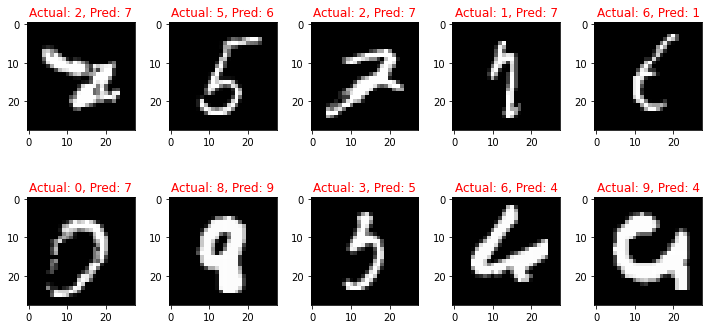

In [16]:
misclassified_images(model, test_loader)# Misclassified images LN

### L1 + BN

In [17]:
model =  Net(normalizationMethod='BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, runName='BN',  L1flag=True)
    scheduler.step()
    test(model, device, test_loader, runName='BN')

EPOCH: 0


Loss=0.1582089215517044 Batch_id=468 Accuracy=89.05: 100%|██████████| 469/469 [00:18<00:00, 25.52it/s]



Test set: Average loss: 0.0734, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.04407811537384987 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0442, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.07392102479934692 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]



Test set: Average loss: 0.0358, Accuracy: 9892/10000 (98.92%)

EPOCH: 3


Loss=0.03317276015877724 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]



Test set: Average loss: 0.0362, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.023629527539014816 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0291, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.05107557028532028 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]



Test set: Average loss: 0.0282, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.039369624108076096 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]



Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.040691062808036804 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:18<00:00, 25.85it/s]



Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.027674954384565353 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.75it/s]



Test set: Average loss: 0.0224, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.05734657123684883 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 24.93it/s]



Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.051216281950473785 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.08919396996498108 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0225, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.10892381519079208 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]



Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.03024463728070259 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]



Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.053700752556324005 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.05435786023736 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.04157150164246559 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:18<00:00, 25.79it/s]



Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.029901228845119476 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.09659821540117264 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]



Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.03404064476490021 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]



Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)



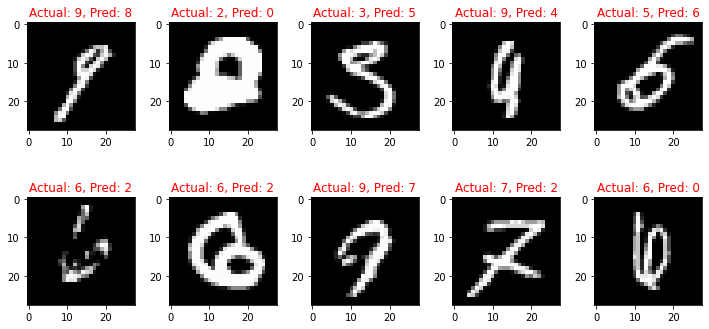

In [18]:
misclassified_images(model, test_loader)# Misclassified images L1+BN

### Plotting Training and Test loss

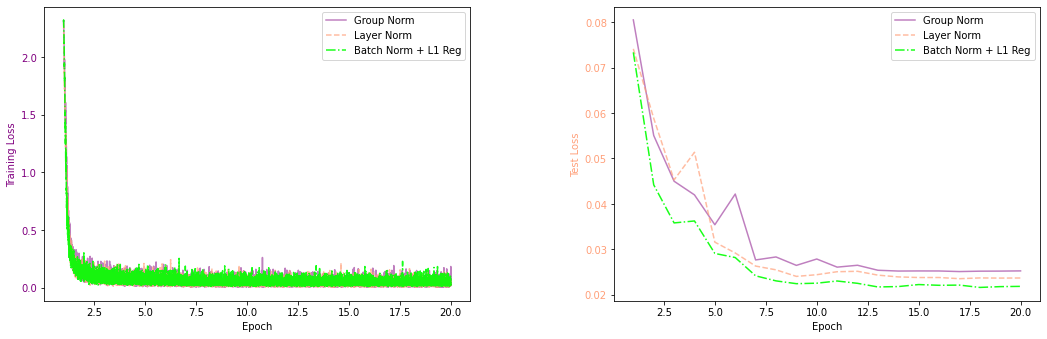

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-dark-palette')

fig, ax = plt.subplots(1, 2)

color1 = 'purple'
color2 = 'lightsalmon'
color3 = 'lime'
linestyle1 = '-'
linestyle2 = '--'
linestyle3 = '-.'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_losses['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_losses['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Loss', color=color1)
ax[0].plot(train_epoch_linspace, train_losses['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[0].plot(train_epoch_linspace, train_losses['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[0].plot(train_epoch_linspace, train_losses['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='upper right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Loss', color=color2)
ax[1].plot(test_epoch_linspace, test_losses['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_losses['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[1].plot(test_epoch_linspace, test_losses['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='upper right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()

### Plotting Train and Test Accuracy

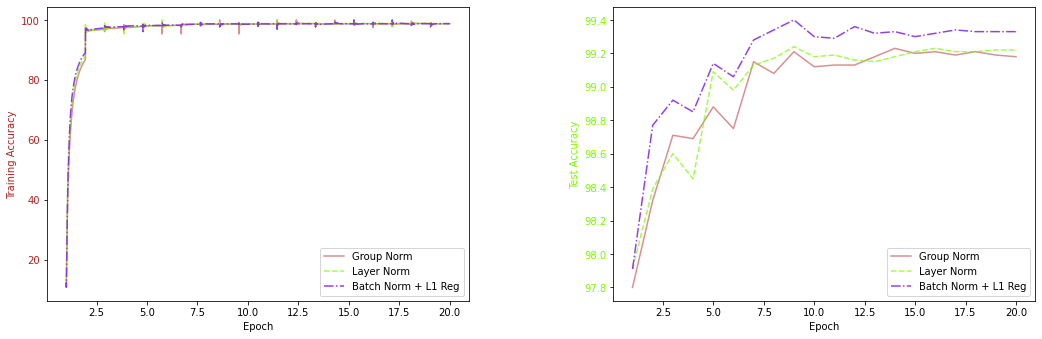

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-deep')

fig, ax = plt.subplots(1, 2)

color1 = 'firebrick'
color2 = 'lawngreen'
color3 = 'blueviolet'
linestyle1 = '-'
linestyle2 = '--'
linestyle3 = '-.'

train_epoch_linspace = np.linspace(1, EPOCHS, len(train_acc['GN']))
test_epoch_linspace = np.linspace(1, EPOCHS, len(test_acc['GN']))
#Left plot

ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training Accuracy', color=color1)
ax[0].plot(train_epoch_linspace, train_acc['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[0].plot(train_epoch_linspace, train_acc['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[0].plot(train_epoch_linspace, train_acc['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[0].tick_params(axis='y', labelcolor=color1)
ax[0].legend(loc='lower right')
#Right plot

ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Test Accuracy', color=color2)
ax[1].plot(test_epoch_linspace, test_acc['GN'], color=color1, linestyle=linestyle1,alpha=0.5, label='Group Norm')
ax[1].plot(test_epoch_linspace, test_acc['LN'], color=color2, linestyle=linestyle2,alpha=0.7, label='Layer Norm')
ax[1].plot(test_epoch_linspace, test_acc['BN'], color=color3, linestyle=linestyle3,alpha=0.9, label='Batch Norm + L1 Reg')
ax[1].tick_params(axis='y', labelcolor=color2)
ax[1].legend(loc='lower right')

fig.tight_layout()
fig.set_size_inches(16, 5)
plt.show()